In [1]:
import sys
sys.path.append('..')
from typing import Dict

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import json

import torch
from torch.nn import Module
import torch.nn.functional as F
from torch.nn.utils import prune

import seaborn as sns
sns.set()

#from models import get_net
from utils.denoising_utils import *
from utils.common_utils import np_to_pil, pil_to_np, get_fname
from utils.viz_utils import np_eval_plot
from train_utils import get_net_and_optim, get_mc_preds, get_imgs

from BayTorch.freq_to_bayes import MCDropoutVI, MeanFieldVI
from BayTorch.inference.losses import uceloss
from BayTorch.inference.utils import uncert_regression_gal, prune_weights_ffg, prune_weights
import BayTorch.visualize as V

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

../BayTorch/visualize/visualization.py:7: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble'] = [


In [2]:
def get_trained_net(net_info: dict, state_dict: dict, task: str) -> Module:
    
    if task == 'denoising':
        net_structure = json.load(open("./configs/net_den.json"))
    elif task == 'super_resolution':
        net_structure = json.load(open("./configs/net_inp.json"))
    elif task == 'inpainting':
        net_structure = json.load(open("./configs/net_inp.json"))

    net, optimizer = get_net_and_optim(net_specs=net_info, optim_specs=None, **net_structure)
    
    net.load_state_dict(state_dict)
    return net#.type(dtype)

In [22]:
task = "denoising"
log_dir = "/media/fastdata/toelle/logs_midl_sr"
#runs = [f"{log_dir}/prior_mu_0.0_prior_sigma_0.1_kl_type_forw_beta_1e-0_xray_02_02_2021_19_19_13"]
#runs = [f"{log_dir}/prior_mu_0.0_prior_sigma_0.1_beta_1e-0_kl_type_forw_skin_lesion3_02_03_2021_19_49_52"]
runs = [f"{log_dir}/sr_dip_mr0"]#, f"{log_dir}/prior_mu_0.0_kl_type_forw_beta_1e-0_prior_sigma_0.07_mri0_02_12_2021_18_13_13"]
labels = ["DIP", "MFVI"]

In [23]:
def get_task_specifics(imgs: Dict[str, np.ndarray], task: str, net_info: Dict = None):
    if task == "denoising":
        return np_to_torch(imgs['noisy']), None, torch.ones(1)
    elif task == "super_resolution":
        factor = net_info["factor"]
        kernel_type = net_info["kernel_type"]
        downsampler = Downsampler(n_planes=imgs['LR_np'].shape[0]+1, factor=factor, kernel_type=kernel_type, kernel_width=2*factor, 
                                  sigma=0.5, phase=0.5, preserve_size=True)
        return np_to_torch(imgs["LR_np"]), downsampler(), torch.ones(1)
    elif task == "inpainting":
        return np_to_torch(imgs["gt"]) * np_to_torch(imgs["mask"]), None, np_to_torch(imgs["mask"])

/home/toelle/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


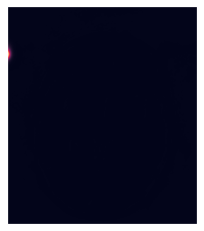

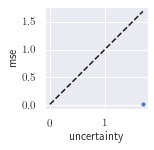

In [24]:
mc_iter = 25

losses = {}
psnrs = {}
ssims = {}

ale_maps = []
epi_maps = []
uncert_maps = []

for label, run in zip(labels, runs):
    results = torch.load(f"{run}/results.pt")
    net_info = json.load(open(f"{run}/net_info.json"))
    img_name = net_info["img_name"]
    imsize = net_info["imsize"]
    #img_name = "xray"
    #imsize = -1
    
    imgs = get_imgs(img_name, task, imsize=imsize)#, sigma=net_info["sigma"])
    img_corrupted_torch, downsampler, mask = get_task_specifics(imgs, task, net_info)
    img_corrupted_torch = img_corrupted_torch.cuda()
    
    psnrs[label] = results["psnr_gt_sm"]
    ssims[label] = results["ssim_gt_sm"]
    losses[label] = results["mse_corrupted"]
    
    net = get_trained_net(net_info, results["state_dict"], task)
    net_input = results["net_input"]#.type(dtype)
    
    if results["sgld_imgs"] is None:
        
        img_list = get_mc_preds(net.cuda(), net_input.cuda(), mc_iter)
        ale, epi, uncert = uncert_regression_gal(img_list, reduction=None)

        out_torch_mean = torch.mean(torch.cat(img_list, dim=0)[:], dim=0, keepdim=True)
        
    else:
        sgld_imgs = results["sgld_imgs"]
        if sgld_imgs[0].shape[0,0] == 2:
            ale, epi, uncert = uncert_regression_gal(sgld_imgs)
            out_torch_mean = torch.mean(torch.cat(sgld_imgs, dim=0)[:,:-1], dim=0)
        else:
            sgld_imgs = torch.cat(sgld_imgs, dim=0)
            epi = uncert = torch.var(sgld_imgs[:], dim=0, keepdim=True)
            ale = torch.zeros(epi.size())
            out_torch_mean = torch.mean(sgld_imgs[:], dim=0)
    
    mse_err = F.mse_loss(out_torch_mean[:,:-1] * mask.cuda(), img_corrupted_torch, reduction='none')
    mse_err = torch.mean(mse_err, dim=1, keepdim=True)
    
    uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(mse_err, uncert, n_bins=10, outlier=0.02)

    plt.imshow(uncert.cpu().numpy()[0,0])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    V.plot_uncert(err_in_bin.cpu().numpy(), avg_sigma_in_bin.cpu().numpy())
    plt.show()

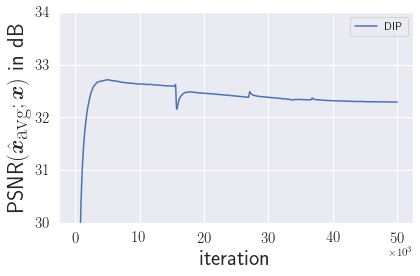

In [28]:
xs = [range(len(list(psnrs.values())[i])) for i in range(len(list(psnrs.values())))]
np_eval_plot(xs, psnrs.values(), labels=psnrs.keys(), ylabel=r'PSNR$(\hat{\bm{x}}_{\textrm{avg}};\bm{x})$ in dB', xtlf='sci', sigma=50, ylim=[30, 34])#, path='psnrs.pdf')

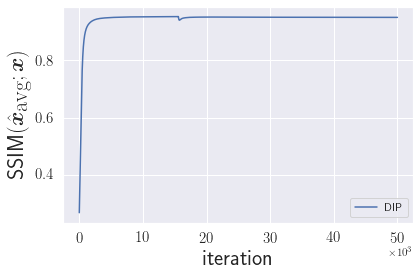

In [26]:
np_eval_plot(xs, ssims.values(), labels=ssims.keys(), ylabel=r'SSIM$(\hat{\bm{x}}_{\textrm{avg}};\bm{x})$', xtlf='sci')#, path='ssims.pdf')

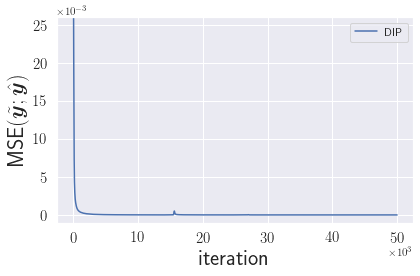

In [27]:
np_eval_plot(xs, losses.values(), labels=losses.keys(), ylabel=r'MSE$(\tilde{\bm{y}};\hat{\bm{y}})$', sigma=50, ytlf='sci', xtlf='sci', 
             ylim=[-0.001,0.026])#, path='mses.pdf')

In [14]:
for key, values in psnrs.items():
    print(f"{key}: {np.array(values).max()}, {np.mean(np.array(values)[-100:])}, {np.array(values)[-1]}")

DIP: 32.87277579737433, 32.288796477427596, 32.28860700255234
MFVI: 32.968831269442006, 32.60982510010183, 32.59033427824657
